### The purpose of this notebook is to show Partial dependence plot and Shap Values built on a Random Forest Model

### Libraries Used

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from scipy.stats import kurtosis,skew,boxcox,yeojohnson
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,classification_report
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from pdpbox import pdp, get_dataset, info_plots
import shap

### Read data

In [24]:
final_df=pd.read_csv(r'C:\Users\Yogesh\Documents\Documents\Spring20\Research_paper\Transform.csv')

### Recrusive feature selection -Logistic regression

In [349]:
sc=StandardScaler()
df_std=sc.fit_transform(final_df.loc[:, final_df.columns != 'Target'])
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(df_std, final_df['Target'])
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False  True False  True  True False  True False False
  True  True  True  True  True False False False False  True False  True
  True False False False False False False False False False  True  True
  True  True  True  True  True False False  True False  True False False
  True False]
[ 1  1  1 24  1  5  1  1  2  1 18 26  1  1  1  1  1 11 19 14 21  1 20  1
  1 25 22 15 16  7 10 17  6  4  1  1  1  1  1  1  1 12 13  1 23  1  8  3
  1  9]


In [357]:
x_cols=final_df.loc[:, final_df.columns != 'Target'].columns
feature_names = np.array(x_cols)

In [358]:
feature_names[rfe.support_]

array(['funded_amnt', 'int_rate', 'installment', 'dti', 'inq_last_6mths',
       'pub_rec', 'revol_util', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util',
       'percent_bc_gt_75', 'total_il_high_credit_limit', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'ownership_MORTGAGE',
       'ownership_Other', 'verify_Source Verified'], dtype=object)

### Final set of variables that will be used in all models

In [10]:
Final_variables=['funded_amnt', 'int_rate', 'installment', 'dti', 'inq_last_6mths',
       'pub_rec', 'revol_util','total_pymnt',
       'total_rec_late_fee', 'last_pymnt_amnt',
       'acc_open_past_24mths',
       'percent_bc_gt_75', 'total_il_high_credit_limit', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E','grade_F','ownership_MORTGAGE',
       'ownership_Other','ownership_OWN', 'verify_Source Verified','verify_Not Verified','verify_Verified']

### Scaling the dataset

In [11]:
sc=StandardScaler()
X=sc.fit_transform(final_df[Final_variables])
y=final_df['Target']
X_imputed_df = pd.DataFrame(X, columns = Final_variables)

    

### Train Test Split

In [12]:
 X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y,stratify=y, test_size=0.2, random_state=0)

### Stats Model Logistic regression for Interpretation

logit_model=sm.Logit(y,X_imputed_df)
result=logit_model.fit()
print(result.summary2())

###  sklearn Logistic regression for prediction

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.97


In [16]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[151496   1468]
 [  4349  33739]]


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    152964
           1       0.96      0.89      0.92     38088

    accuracy                           0.97    191052
   macro avg       0.97      0.94      0.95    191052
weighted avg       0.97      0.97      0.97    191052



### Logistic regression Model ROC curve

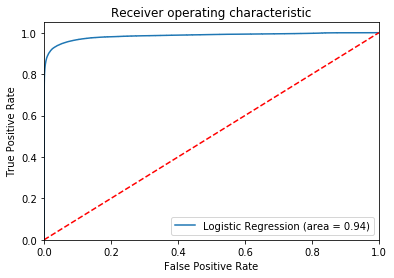

In [33]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Random forest using Grid SearchCV

In [47]:
param_grid = [
    {'n_estimators' : [100, 200, 400],
     'max_features' : ['auto', 'sqrt'],
     'max_depth' : [5, None],
     'bootstrap' : [True, False]
    }
]
forest_cls = RandomForestClassifier()
grid_search = GridSearchCV(forest_cls, param_grid,n_jobs=-1)


In [48]:
grid_search.fit(X_train, y_train) 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [49]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [50]:
grid_search.best_score_

0.9918097892581179

In [51]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
grid_search.score(X_test,y_test)

0.9922952913342964

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = False,
                               max_features = 'sqrt',
                               max_depth=None)

In [14]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred_rf=rf_model.predict(X_test)

In [22]:
confusion_matrix_rf= confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)

[[152700    264]
 [  1233  36855]]


In [18]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    152964
           1       0.99      0.97      0.98     38088

    accuracy                           0.99    191052
   macro avg       0.99      0.98      0.99    191052
weighted avg       0.99      0.99      0.99    191052



### Random Forest ROC curve

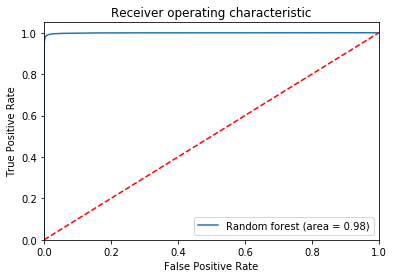

In [28]:
rf_roc_auc = roc_auc_score(y_test, rf_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Partial Dependence Plot

In [39]:
from sklearn.inspection import plot_partial_dependence

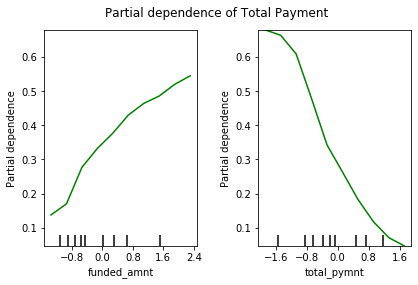

In [43]:
features = [0,7]
plot_partial_dependence(rf_model, X_test[:100], 
                        features,feature_names=['funded_amnt', 'int_rate', 'installment', 'dti', 'inq_last_6mths',
                                                'pub_rec', 'revol_util','total_pymnt',
                                                'total_rec_late_fee', 'last_pymnt_amnt'],
                                                grid_resolution=10) 
fig = plt.gcf()
fig.suptitle('Partial dependence of Total Payment')
plt.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.3)


### Shap values

In [41]:
shap_values =shap.TreeExplainer(rf_model).shap_values(X_test[:100])

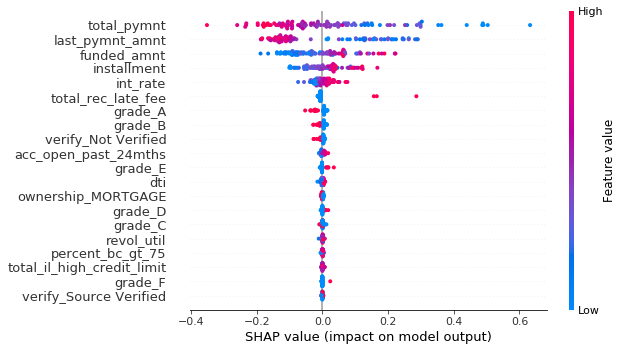

In [42]:
shap.summary_plot(shap_values[1], X_test[:100],plot_size=0.2)